# MEEP - Studying a two-lens refractor telescope

In [1]:
import numpy as np
import meep as mp

## A Simple 2D Example

(Most of what is explained here is explained in Meep's documentation, this is only examples for the study of a two-lens refractor telescope)

Before actually running a big 3D simulation, Meep can be understood through a 2D example.

Let's just a have a monochromatic plane wave incoming from vacuum through a dielectric.

Meep can be understood through 2 steps in the code :
1. Defining the environment
2. Running the simulation and getting the results

A note to understand MEEP's times and distances :
Everything in MEEP is done in MEEP units, with c=1. So an electromagnetic wavec will propagate through 1 meep unit of distance within 1 Meep unit of time.

### 1. Defining the environment

The first element to define is the cell size. Let's begin with a 2D 10x10 cell.

In [6]:
x_cell = 10
y_cell = 10

Because we want to have some boundary condition on the sides, which is most of the time Perfectly Matched Layers, i.e. perfect absorbtion of the waves, and it overlaps on the inside of the cell in Meep, we want to define it as well so that when we create the computational cell, it accounts for this extra size.

Let's put PML here with thickness 1 :

In [8]:
d_pml = 1

The cell is then defined with a Vector3 obejct such as :

In [12]:
cell = mp.Vector3(x_cell+2*d_pml, y_cell+2*d_pml, 0)

We may now define the PML object that will be used later in the sim. It is important to note that the PML will overlap on any other material.

In [14]:
pml_layers = [mp.PML(thickness = d_pml)] #, direction = mp.X)] if we want only PML on the +/-x sides of the cell

Next, we can define the objects that will be constituents of the system, here a simple dielectric block of index 1.5:

In [16]:
n = 1.5
geometry = [mp.Block(center = mp.Vector3(0,0,0), 
                     size = mp.Vector3(2,10,0), 
                     material = mp.Medium(index = n))]

There are other ways to define materials, but this one will do for now.

Then comes defining the frequency (for a broadband source, the main, center, frequency) and the resolution, because they come together as explained below.

In [20]:
f = 1
resolution = 10

Frequency is given in units of c: a frequency of 1 gives a wavelength of 1 in units of meep length

Set the frequency and resolution so that there are roughly 8 pixels per wavelength

Frequency = Wavelength/Meep_unit_distance

Resolution = Pixel/Meep_unit_distance

==> Resolution/Frequency > 8

And finally, the source can be defined as : 

In [18]:
source = [mp.Source(mp.ContinuousSource(f),
                      component=mp.Ez,
                      center=mp.Vector3(-5,0,0),
                      size=mp.Vector3(0,12,0))]

### 2. Running the simulation

Defining a simulation is pretty straightforward, it's just using the previously defined variables :

In [21]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=source,
                    geometry=geometry,
                    resolution=resolution)

Now we can run it, for let's say 20 Meep time units :

In [23]:
sim.run(until = 20)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000566006 s
Working in 2D dimensions.
Computational cell is 12 x 12 x 0 with resolution 10
     block, center = (0,0,0)
          size (2,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.120557 s
-----------


FloatProgress(value=0.0, description='0% done ', max=20.0)

run 0 finished at t = 20.0 (400 timesteps)


We can get a plot of the field at the end :

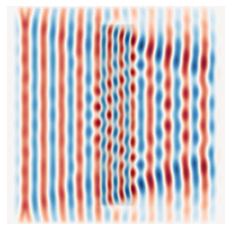

In [37]:
import matplotlib.pyplot as plt
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha = 0.9)
plt.axis('off')
plt.show()

We can even produce an animated version of our simulation with the following lines. Unfortunately, Jupyter doesn't handle the live animation plotting, but we can still save it as an mp4.

-----------
Initializing structure...
time for choose_chunkdivision = 0.000243902 s
Working in 2D dimensions.
Computational cell is 12 x 12 x 0 with resolution 10
     block, center = (0,0,0)
          size (2,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.138283 s
-----------


FloatProgress(value=0.0, description='0% done ', max=20.0)

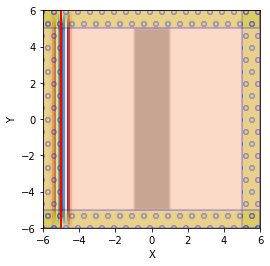

Meep progress: 7.0/20.0 = 35.0% done in 4.0s, 7.5s to go
on time step 150 (time=7.5), 0.0279355 s/step
Meep progress: 16.0/20.0 = 80.0% done in 8.1s, 2.0s to go
on time step 330 (time=16.5), 0.0227418 s/step
run 7 finished at t = 20.0 (400 timesteps)
Generating MP4...


In [32]:
sim.reset_meep() #Resetting the simulation
animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       realtime=True,
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'none'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})



sim.run(mp.at_every(.5,animate),until=20)

N_fps = 5 #sets the number of frames per second for the movie. Here it has 40 frames, so let's just run at 5fps.
animate.to_mp4(N_fps, 'test.mp4')

Here we used mp.at_every which executes a Meep function at every tau time step. In the previous examples tau=0.5, the function animate produces a plot every .5 units of Meep time. 

Another way to produce animated plots is the following, which outputs a png of the Ez field at each specified time step, and the converting them in a single gif using the shell

In [33]:
#sim.use_output_directory() #Meep outputs files in a separate folder
#sim.run(mp.at_every(.5 , mp.output_png(mp.Ez, "-Zc /home/alexei/mini_conda/envs/mp/share/h5utils/colormaps/bluered")), until=20)

There are a few remarks to be done on this : 
- Meep can only output a single component (mp.Ez, mp.Hy, etc...) and not combinations of them
- The path specified here is the path to the cmap corresponding to Blue&Red in h5utils, because Meep uses h5topng and apparently needs this path to work
- Instead of writing .5 and 10 for time steps and total time, it may be more convenient to express it in units of frequency, i.e. for every .5/f (every half period) and for 10/f (10 periods) which works for every frequency

There is also the option to output the Ez field throughout the whole sim at all times in a single h5 files, but this leads to (very) heavy files :

In [34]:
# sim.run(mp.to_appended("ez", mp.at_every(.5, mp.output_efield_z)), until=20)

The to_appended allows to output it all in a single file, that is, stacking all time slices together.

### 3. Going to 3D ?

Everything happens much the same way in 3D. In the previous example, because we specified a 2D cell, everything Meep subsquently did, it did so in 2D. Going to 3D only requires to extend the source in the z direction as well as the cell and the materials. Of course, this leads to (much) heavier calculations.

## 2-Lens refractor

We can stay in a 2D case for now and try to make a 2-Lens telescope. The system will have to be a bit bigger, but we can reduce the frequency (and thus the resolution) if need be, so that the grid size remains reasonable.

In [12]:
### Resolution ##########
resolution = 2

### PML #################
dpml = 1
pml_layers = [mp.PML(thickness = dpml)]#, direction = mp.X)]

### Size of cell ########
sx = 100 
sy = 50        
cell = mp.Vector3(sx+2*dpml, sy+2*dpml, 0)

### Sources #############
f = 0.2
sources = [mp.Source(mp.ContinuousSource(f),
                      component=mp.Ez,
                      center=mp.Vector3(-45,0,0), #Putting our source at the far-left
                      size=mp.Vector3(0,50,0))]

Now we need to make two dielectric lenses. Unfortunately, Meep only handles a few basic shapes, and anything that is a deviation from that needs special treatment. Fortunately, Meep does accept user-defined functions for the dielectric function in space, epsilon. So we will need to do that, build a function that returns the lenses dielectric constant ($ \varepsilon = n²$) for points within the lenses and 1 outside.

Here is presented such a function for two perfectly spheric lenses (the aspheric parameter k is set to 0). The first lens is curved on one side and flat on the other, the 2nd lens is curved on both sides to provide an example.

In [4]:
### Lenses ##############
n = 1.5  #index
epsilon = n**2

"""Lens 1"""
R1   = 60           #First lens Radius
x1_L = -30          #First lens left surface center position
x1_R = -20          #First lens right surface center position
k1   = 0            #First lens aspheric parameter
ymax_1 = 25         #First lens semi-diameter

#Point projected on optical axis where the curved surface hits the outer diameter
x1_under_radius = (ymax_1**2/R1) / (1 + np.sqrt(1 - (1+k1)*ymax_1**2/R1**2)) + x1_L

def lens_1(P):
    x = P.x
    y = P.y
    #Part of lens that extends to the semi-diameter
    if x >= x1_under_radius:
        return epsilon
    #Part of lens where surface computation is required
    else :
        c = (y**2/R1) / (1 + np.sqrt(1 - (1+k1)*y**2/R1**2)) + x1_L
        if c<=x :
            return epsilon
        else :
            return 1
"""Lens 2"""
R2   = 60           #2nd lens Radius
x2_L = 20           #2nd lens left surface center position
x2_R = 30           #2nd lens right surface center position
k2   = 0            #2nd lens aspheric parameter
ymax_2 = 25         #2nd lens semi-diameter

R2_R = 6000         #2nd lens right surface radius
k2_R = 0            #2nd lens right surface conic parameter

#Point projected on optical axis where the curved surface hits the outer diameter
x2_under_radius_R = (ymax_2**2/R2_R) / (1 + np.sqrt(1 - (1+k2_R)*(ymax_2**2/R2_R**2))) + x2_R

def lens_2(P):
    x = P.x
    y = P.y
    #Part of lens that extends to the semi-diameter
    if x >= x2_under_radius_R:
        return epsilon
    #Part of lens where surface computation is required
    else :
        surface_L = (y**2/R2) / (1 + np.sqrt(1 - (1+k2)*y**2/R2**2)) + x2_L
        surface_R = (y**2/R2_R) / (1 + np.sqrt(1 - (1+k2_R)*y**2/R2_R**2)) + x2_R
        if surface_L<=x and x<=surface_R :
            return epsilon
        else :
            return 1

"""Lenses together"""
def lenses(P):
    x = P.x
    y = P.y
    #Compute lenses function only where it's interesting
    if np.abs(y)<=150 and x1_L<=x and x<=x1_R:
        return lens_1(P)
    if np.abs(y)<=150 and x2_L<=x and x<=x2_under_radius_R:
        return lens_2(P)
    
    #To get perfectly reflective material on all sides of the cell :
    # if np.abs(y) >= 150 :
    #     return -mp.inf
    
    #Returns vacuum where there are no lenses
    else :
        return 1

Now we can run the simulation :

In [7]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    resolution=resolution,
                    epsilon_func = lenses) #To use the custom lenses

sim.run(until = 25/f)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 102 x 52 x 0 with resolution 2
time for set_epsilon = 2.28005 s
-----------


FloatProgress(value=0.0, description='0% done ', max=125.0)

run 0 finished at t = 125.0 (500 timesteps)


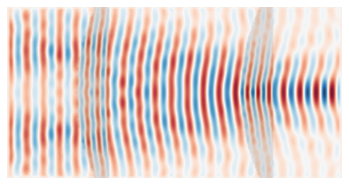

In [8]:
import matplotlib.pyplot as plt
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha = 0.9)
plt.axis('off')
plt.show()

Even if the system shown in this example has not been set to proper focus (the different values are arbitrary), we can still see that the wave intensity is stronger in a smaller area of the image plane. Ideally, the focusing would come to a single point in the image plane, but for this you would want to have the proper lenses with the proper spacings between them.

So this is the basics of a two lens telescope in Meep. Then, using this, we can use the various tools provided by Meep for further analysis. We could for example use a broadband gaussian source and study how the different frequencies are propagated in the system. 

Let's see for example how we would make a plane wave coming in at an angle. For this, we can provide a custom source function, in very much the same way we did for the lenses, that returns the amplitude for a given point in space.

In [22]:
### Tilted sources ##############
theta = 10 * np.pi/180          #Tilt angle
delta_x = np.sin(theta)*50      #x-projection of the source
delta_y = np.cos(theta)*50      #y-projection of the source
slope = np.tan(theta)           #Slope

def source_tilt(P):
    x = P.x
    y = P.y
    #Only compute source in the zone of interest
    if x>=-delta_x/2 and x<=delta_x/2 :
        #Eqn of slope +/- .2 to give it thickness        
        if x>= y*slope - 0.2 and x<= y*slope + 0.2:
            return 1
        else :
            return 0
    else :
        return 0
    
source_tilted = [mp.Source(mp.ContinuousSource(f), 
                     volume = mp.Volume(center = mp.Vector3(-45,0,0),size=mp.Vector3(10,50,0)), 
                     component = mp.Ez, 
                     amp_func = source_tilt)]

The function for source tilt is computed with coordinates in which the center of the source provided in center=(...) is the origin. The size gives the volume in which Meep should be computing the source_tilt function.

In [23]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=source_tilted,
                    resolution=resolution,
                    epsilon_func = lenses) #To use the custom lenses

sim.run(until = 25/f)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000204086 s
Working in 2D dimensions.
Computational cell is 102 x 52 x 0 with resolution 2
time for set_epsilon = 2.2924 s
-----------


FloatProgress(value=0.0, description='0% done ', max=125.0)

run 0 finished at t = 125.0 (500 timesteps)


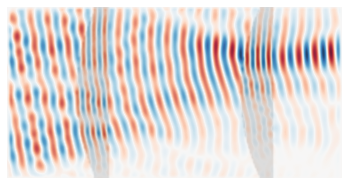

In [25]:
import matplotlib.pyplot as plt
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha = 0.9)
plt.axis('off')
plt.show()

### A 3D Focused two-lens refractor

Now that these basics are done, let's make it into 3D with a system of two-lenses that we know to give proper focus (and even telecentricity). This is only possible with aspheric lenses, hence the introduction of an aspheric parameter earlier.

To achieve a 3D system of lenses, we are going to have to use Meep's ability to read an h5 file containing the dielectric constant map, because the way it has been done in the previous example gets quite slow when dealing with large systems.

This map has two main requirements, on top of being an accurate representation of our system :
- Being the same proportions as the cell defined in Meep (this may seem trivial, but if it isn't the same proportions Meep will just stretch the map without warning you that there's something wrong)
- Being as high resolution as possible, because this will reduce any errors that might arise when Meeps makes an interpolation of the map, but take note that h5 files get very heavy and precision is a compromise between this file size and the accuracy

The creation of this dielectric map can be found in here (put a link here or smth), it only needs to be run once so that the h5 is saved, but is a bit heavy for the notebook.


In [2]:
import h5py 

filename = 'epsilon_map.h5'
map = h5py.File(filename, 'r')

1e+20


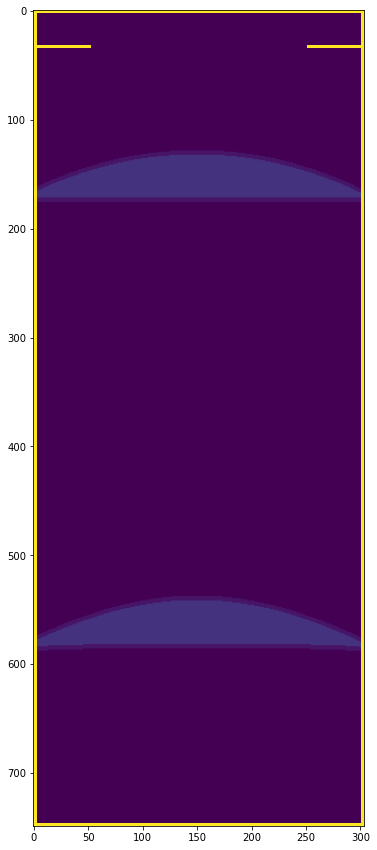

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

plt.figure(figsize = (60,15))
plt.imshow(map['eps'][:,:,152], norm = colors.Normalize(vmin=1, vmax = 10))

This is how the system looks like, with an aperture stop at the entrance, two lenses each with an anti reflection coating of thickness $\frac{\lambda}{4}$ and index $n_{AR}=\sqrt{n_{lens}}$. The x=cst section of the system show that it is tubular : 

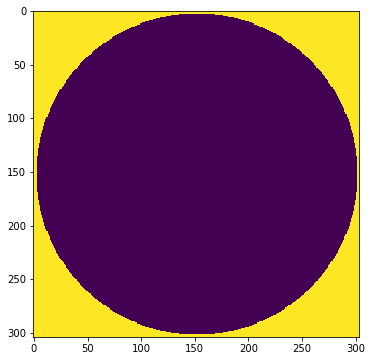

In [20]:
plt.figure(figsize = (6,6))
plt.imshow(map['eps'][30], norm = colors.Normalize(vmin=1, vmax = 10))

In the following, we put a .5 resolution for computing time reasons. 
The source is just a circular source coming in like a plane wave before the aperture.
The command to use the h5 file as the system is found in the sim definition.
The frequency is put so that resolution/frequency = 8. This is however not the frequency at which the system should work, in here the lenses have a diameter of 300mm and the appropriate wavelength would be 1mm, corresponding to a frequency of 1. This would require a resolution of 8, so 16³ times the grid points that there are now, the computation time would probably explode.

In [3]:
### Resolution ##########
resolution = 2

### PML #################
dpml = 2 
pml_layers = [mp.PML(thickness = dpml)]

### Size of cell ########
sx = np.int(np.around(744.704))    # size of cell in X direction
sy = 300        # size of cell in Y direction
sz = 300        # size of cell in Z direction
cell = mp.Vector3(sx+2*dpml, sy+2*dpml, sz+2*dpml)

### Circular aperture (Source) ###

radius_sq = 200**2
def source_aperture_func(P):
    y=P.y
    z=P.z
    if y**2 + z**2 < radius_sq:
        return 1
    else :
        return 0
    
fcen = 0.25 
source_aperture = [mp.Source(mp.ContinuousSource(fcen), 
                     volume = mp.Volume(center = mp.Vector3(-357.352,0,0),size=mp.Vector3(0,300,300)), 
                     component = mp.Ez, 
                     amp_func = source_aperture_func)]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    #geometry=geometry, #To use the build made with meep shapes
                    sources=source_aperture,
                    resolution=resolution,
                    epsilon_input_file = 'epsilon_map.h5:eps')

Now we can run the sim. 
The following command can be run many times, the 1st time requires some time to read the dielectric map, but once it has been read it's kept in memory, so executing this line once more only continues the simulation from where it left.

In [ ]:
sim.run(until=10)

-----------
Initializing structure...
read in 749x304x304 epsilon-input-file "epsilon_map.h5:eps"
time for choose_chunkdivision = 0.00413394 s
Working in 3D dimensions.
Computational cell is 749 x 304 x 304 with resolution 2
subpixel-averaging is 56.4844% done, 3.08266 s remaining
subpixel-averaging is 59.1321% done, 2.76467 s remaining
subpixel-averaging is 21.3773% done, 14.7137 s remaining
subpixel-averaging is 44.2495% done, 5.04364 s remaining
subpixel-averaging is 68.7475% done, 1.81887 s remaining
subpixel-averaging is 92.5354% done, 0.32283 s remaining
subpixel-averaging is 25.2267% done, 11.8574 s remaining
subpixel-averaging is 50.3413% done, 3.94671 s remaining
subpixel-averaging is 75.6054% done, 1.2907 s remaining
subpixel-averaging is 25.2267% done, 11.8625 s remaining
subpixel-averaging is 49.4444% done, 4.09066 s remaining
subpixel-averaging is 72.8398% done, 1.49184 s remaining
subpixel-averaging is 97.2257% done, 0.114201 s remaining
subpixel-averaging is 25.2641% don

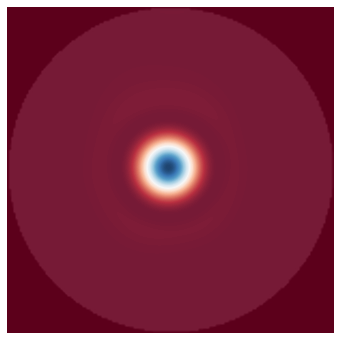

In [25]:
import matplotlib.pyplot as plt
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)[-2,:,:]
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)[-2,:,:]
plt.figure(figsize = (14,6))
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose()**2, interpolation='spline36', cmap='RdBu', alpha = 0.9)
plt.axis('off')
plt.show()

So here is our two-lens refractor telescope in 3D. Depending on your computer it might take longer (quite unlikely) or shorter time (I'm not sure to what extent) to compute the previous simulation. And it's only a .5 resolution.

## Getting an Airy Spot, in 2D with smaller wavelength.

In [2]:
### Resolution ##########
resolution = 4

### PML #################
dpml = 2
pml_layers = [mp.PML(thickness = dpml)]#, direction = mp.X)]

### Size of cell ########
sx = np.int(np.around(744.704))    # size of cell in X direction
sy = 300                           # size of cell in Y direction      
cell = mp.Vector3(sx+2*dpml, sy+2*dpml, 0)

### Sources #############
f = .25
source_aperture = [mp.Source(mp.ContinuousSource(f), 
                     center = mp.Vector3(-357.352,0,0), size=mp.Vector3(0,300,0), 
                     component = mp.Ez)]

### Lenses ##############
n = 1.52  #index
epsilon = n**2

"""Lens 1"""
R1   = 327.365      #First lens Radius
x1_L = -227.352+15     #First lens left surface center position
x1_R = -187.352+15     #First lens right surface center position
k1   = -0.66076     #First lens aspheric parameter
ymax_1 = 150        #First lens semi-diameter

#Point projected on optical axis where the curved surface hits the outer diameter
x1_under_radius = (ymax_1**2/R1) / (1 + np.sqrt(1 - (1+k1)*ymax_1**2/R1**2)) + x1_L

def lens_1(P):
    x = P.x
    y = P.y
    #Part of lens that extends to the semi-diameter
    if x >= x1_under_radius:
        return epsilon
    #Part of lens where surface computation is required
    else :
        c = (y**2/R1) / (1 + np.sqrt(1 - (1+k1)*y**2/R1**2)) + x1_L
        if c<=x :
            return epsilon
        else :
            return 1
"""Lens 2"""
R2   = 269.190      #2nd lens Radius
x2_L = 182.056+15      #2nd lens left surface center position
x2_R = 222.056+15      #2nd lens right surface center position
k2   = -2.4029      #2nd lens aspheric parameter
ymax_2 = 150        #2nd lens semi-diameter

R2_R = 6398.02      #2nd lens right surface radius
k2_R = 1770.36      #2nd lens right surface conic parameter

#Point projected on optical axis where the curved surface hits the outer diameter
x2_under_radius_R = (ymax_2**2/R2_R) / (1 + np.sqrt(1 - (1+k2_R)*(ymax_2**2/R2_R**2))) + x2_R

def lens_2(P):
    x = P.x
    y = P.y
    surface_L = (y**2/R2) / (1 + np.sqrt(1 - (1+k2)*y**2/R2**2)) + x2_L
    surface_R = (y**2/R2_R) / (1 + np.sqrt(1 - (1+k2_R)*y**2/R2_R**2)) + x2_R
    if surface_L<=x and x<=surface_R :
        return epsilon
    else :
        return 1

"""Lenses together"""
def lenses(P):
    x = P.x
    y = P.y
    #Compute lenses function only where it's interesting
    if np.abs(y)<=150 and x1_L<=x and x<=x1_R:
        return lens_1(P)
    elif np.abs(y)<=150 and x2_L<=x and x<=x2_under_radius_R:
        return lens_2(P)
    
    #To get perfectly reflective material on all sides of the cell :
    # if np.abs(y) >= 150 :
    #     return -mp.inf
    
    # Aperture stop :
    #if -342.852<x and x<-341.852 :
    #    if np.abs(y)>100 :
    #        return 10
    #    else :
    #        return 1
    
    #Returns vacuum where there are no lenses   
    else :
        return 1

    
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    #geometry=geometry, #To use the build made with meep shapes
                    sources=source_aperture,
                    resolution=resolution,
                    epsilon_func = lenses)

In [3]:
sim.run(until = 900)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00306511 s
Working in 2D dimensions.
Computational cell is 749 x 304 x 0 with resolution 4
subpixel-averaging is 3.24762% done, 120.025 s remaining
subpixel-averaging is 7.22318% done, 51.5963 s remaining
subpixel-averaging is 11.1987% done, 31.7579 s remaining
subpixel-averaging is 15.2863% done, 22.3384 s remaining
subpixel-averaging is 18.6459% done, 17.5543 s remaining
subpixel-averaging is 22.0615% done, 14.2467 s remaining
subpixel-averaging is 25.1972% done, 11.9048 s remaining
subpixel-averaging is 29.2568% done, 9.69046 s remaining
subpixel-averaging is 33.4563% done, 7.96334 s remaining
subpixel-averaging is 37.7118% done, 6.61807 s remaining
subpixel-averaging is 41.9954% done, 5.54274 s remaining
subpixel-averaging is 46.3629% done, 4.64284 s remaining
subpixel-averaging is 50.6184% done, 3.9232 s remaining
subpixel-averaging is 55.0419% done, 3.27985 s remaining
subpixel-averaging is 59.4934% done, 2.7

FloatProgress(value=0.0, description='0% done ', max=900.0)

Meep progress: 5.75/900.0 = 0.6% done in 4.0s, 624.6s to go
on time step 47 (time=5.875), 0.0859766 s/step
Meep progress: 16.0/900.0 = 1.8% done in 8.0s, 443.1s to go
on time step 129 (time=16.125), 0.0488476 s/step
Meep progress: 26.125/900.0 = 2.9% done in 12.0s, 402.1s to go
on time step 211 (time=26.375), 0.0493185 s/step
Meep progress: 36.5/900.0 = 4.1% done in 16.1s, 379.8s to go
on time step 294 (time=36.75), 0.0484681 s/step
Meep progress: 46.875/900.0 = 5.2% done in 20.1s, 365.5s to go
on time step 377 (time=47.125), 0.0485922 s/step
Meep progress: 57.25/900.0 = 6.4% done in 24.1s, 354.7s to go
on time step 460 (time=57.5), 0.0482403 s/step
Meep progress: 67.625/900.0 = 7.5% done in 28.1s, 346.3s to go
on time step 543 (time=67.875), 0.0487666 s/step
Meep progress: 77.875/900.0 = 8.7% done in 32.2s, 339.6s to go
on time step 625 (time=78.125), 0.0491611 s/step
Meep progress: 88.125/900.0 = 9.8% done in 36.2s, 333.6s to go
on time step 707 (time=88.375), 0.0492457 s/step
Meep p

Meep progress: 710.25/900.0 = 78.9% done in 293.8s, 78.5s to go
on time step 5688 (time=711), 0.0484937 s/step
Meep progress: 720.5/900.0 = 80.1% done in 297.9s, 74.2s to go
on time step 5770 (time=721.25), 0.0490496 s/step
Meep progress: 731.0/900.0 = 81.2% done in 301.9s, 69.8s to go
on time step 5854 (time=731.75), 0.0479506 s/step
Meep progress: 741.5/900.0 = 82.4% done in 305.9s, 65.4s to go
on time step 5938 (time=742.25), 0.0479043 s/step
Meep progress: 752.0/900.0 = 83.6% done in 309.9s, 61.0s to go
on time step 6022 (time=752.75), 0.0478799 s/step
Meep progress: 762.375/900.0 = 84.7% done in 313.9s, 56.7s to go
on time step 6105 (time=763.125), 0.0482337 s/step
Meep progress: 772.875/900.0 = 85.9% done in 318.0s, 52.3s to go
on time step 6189 (time=773.625), 0.0479577 s/step
Meep progress: 783.25/900.0 = 87.0% done in 322.0s, 48.0s to go
on time step 6272 (time=784), 0.0484414 s/step
Meep progress: 793.625/900.0 = 88.2% done in 326.0s, 43.7s to go
on time step 6356 (time=794.5

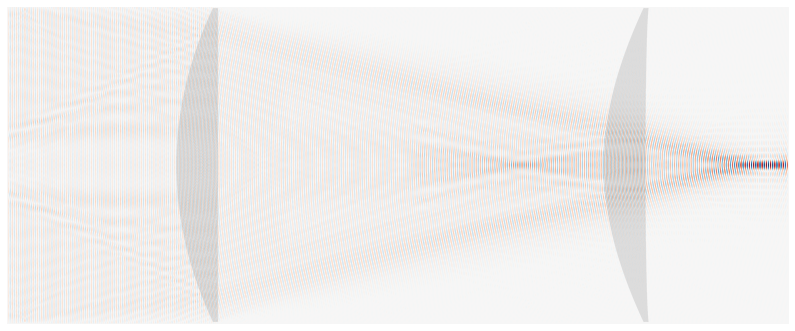

In [4]:
import matplotlib.pyplot as plt
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure(figsize = (14,6))
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha = 0.9)
plt.axis('off')
plt.show()

FloatProgress(value=916.0, description='0% done ', max=916.25, min=916.0)

on time step 7328 (time=916), 36.834 s/step
run 65 finished at t = 916.25 (7330 timesteps)


FloatProgress(value=916.25, description='0% done ', max=916.5, min=916.25)

run 66 finished at t = 916.5 (7332 timesteps)


FloatProgress(value=916.5, description='0% done ', max=916.75, min=916.5)

run 67 finished at t = 916.75 (7334 timesteps)


FloatProgress(value=916.75, description='0% done ', max=917.0, min=916.75)

run 68 finished at t = 917.0 (7336 timesteps)


FloatProgress(value=917.0, description='0% done ', max=917.25, min=917.0)

run 69 finished at t = 917.25 (7338 timesteps)


FloatProgress(value=917.25, description='0% done ', max=917.5, min=917.25)

run 70 finished at t = 917.5 (7340 timesteps)


FloatProgress(value=917.5, description='0% done ', max=917.75, min=917.5)

run 71 finished at t = 917.75 (7342 timesteps)


FloatProgress(value=917.75, description='0% done ', max=918.0, min=917.75)

on time step 7342 (time=917.75), 0.304755 s/step
run 72 finished at t = 918.0 (7344 timesteps)


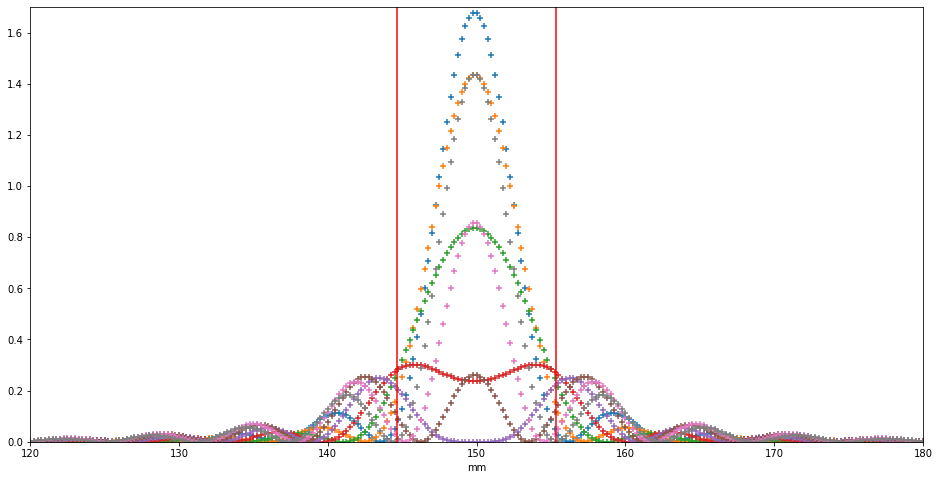

In [19]:
plt.figure(figsize = (16,8))
for k in range(8):
    sim.run(until = .25)
    ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)[-5,:]
    plt.scatter(np.arange(1216)/resolution-2, ez_data**2, marker = '+')
plt.xlabel('mm')
plt.xlim((120,180))
plt.ylim((0,1.7))
max_to_zero = 1.22*2.2*4/2
plt.vlines([150-max_to_zero, 150+max_to_zero], -1, 2, color = 'r')
plt.show()

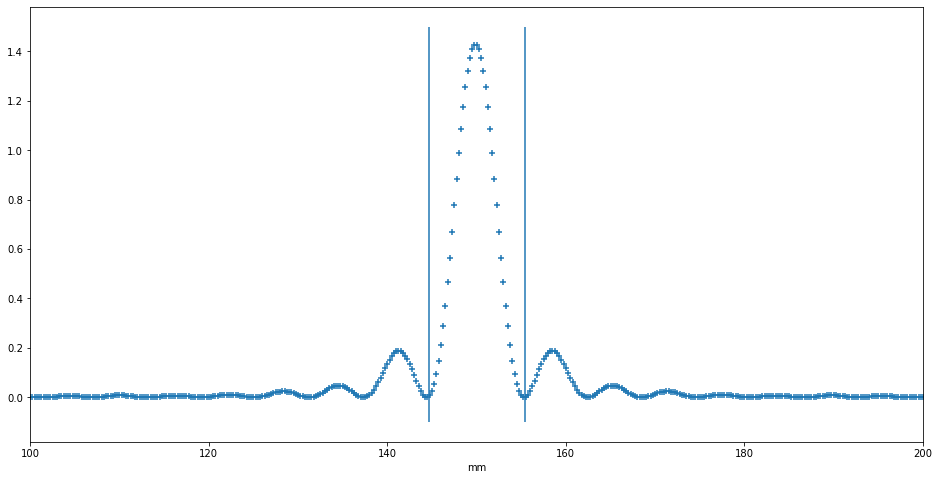

In [11]:
plt.figure(figsize = (16,8))
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)[-5,:]
plt.scatter(np.arange(1216)/resolution-2, ez_data**2, marker = '+')
plt.xlabel('mm')
max_to_zero = 1.22*2.2*4/2
plt.vlines([150-max_to_zero, 150+max_to_zero], -0.1, 1.5)
plt.xlim((100,200))
plt.show()

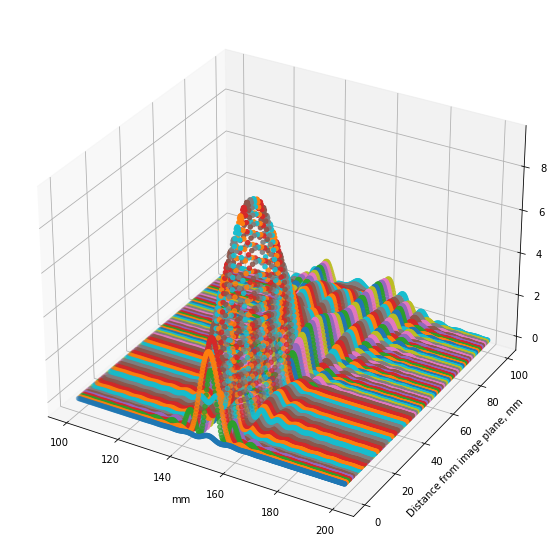

In [55]:
ez_data = sim.get_array(center=mp.Vector3(), size=mp.Vector3(sx+2*dpml, 100), component=mp.Ez)


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
for k in range(100):
    ax.scatter(np.arange(402)/resolution+100, np.ones(402)*k, ez_data[-4-4*k,:]**2)
plt.xlabel('mm')
plt.ylabel('Distance from image plane, mm')
plt.show()

In [42]:
ez_data.shape


(2247, 302)

In [37]:
x2_L - x1_R

369.408

In [7]:
2*1.22*2.2*4

21.472

In [49]:
0.25*1.52

0.38

In [51]:
4/1.52*3

7.894736842105264